# Training neural networks to predict turbulence

Preamble: Run the cells below to import the necessary Python packages

*This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.*

In [1]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


# plt.style.use("dark_background")

### Training a model

+ Given a model $f(\boldsymbol{x}; \boldsymbol{\theta})$ and a dataset $\{(\boldsymbol{x}_i, y_i)\}$, we want to find the parameters $\boldsymbol{\theta}$ that best describe the data.

+ Linear regression had an analytic equation for the weight matrix $\boldsymbol{\theta}$, turns out to minimize the least-squares cost function $J(\boldsymbol{\theta}) = \frac{1}{2} \sum_i (y_i - f(\boldsymbol{x}_i; \boldsymbol{\theta}))^2$.

+ Usually we aren't so lucky as to have an exactly solvable convex optimization problem

+ The next best thing is to have an optimization problem (possibly non-convex) where the loss is a smooth, differentiable function of the weights. In this case, we can use gradient descent and its variants

#### An aside: What if our problem is non-differentiable?

+ Brute force (try random parameters or grid search and see what gives the best result).

+ Genetic algorithms, reinforcement learning

+ Can attempt to use gradient descent, if we can construct a differentiable surrogate function for the true loss


## Revisiting predicting the Reynolds number of a turbulent flow

+ Our dataset consists of snapshots of the velocity field of a turbulent flow, labelled the corresponding Reynolds number.

+ Recall that the Reynolds number is a dimensionless number that characterizes the flow regime of a fluid. The higher the Reynolds number, the more turbulent the flow.

+ Because we are going to use fully-connected nets, we need to downsample the dataset substantially to have a reasonable training time

+ We will implement a data loader that will fetch the dataset, and perform standardization and downsampling.

+ We will also perform a train/test split in the data loader

Dataset size: X_train: (1920, 4096), y_train: (1920,)
Dataset size: X_test: (480, 4096), y_test: (480,)


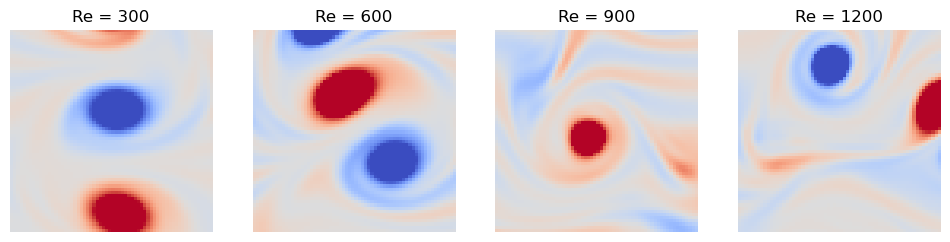

In [107]:
## Load the Reynold number regression dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class ReynoldsDataset:
    """
    Class to load the Reynolds number classification dataset
    
    Parameters:
        downsample (int): Factor by which to downsample the dataset
        split (float): Fraction of data to use for testing
        random_state (int): Random seed for reproducibility
    """

    def __init__(self, downsample=1, split=0.2, random_state=None):
        
        self.random_state = random_state

        all_vorticity_fields = list()
        all_reynolds_numbers = list()

        # Load simulations for different Reynolds numbers
        re_vals = [300, 600, 900, 1200]
        for re_val in re_vals:

            # Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
            # where the first dimension is the time index, the second and third dimensions are the
            # x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
            vfield = np.load(
                f"../resources/von_karman_street/vortex_street_velocities_Re_{re_val}_largefile.npz", 
                allow_pickle=True
            )

            # Calculate the vorticity, which is the curl of the velocity field
            vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0]

            # Crop to wake field only
            vort_field = vort_field[::5, -127:, :][:, 32:96, 32:96]

            # downsample the dataset
            vort_field = vort_field[:, ::downsample, ::downsample]

            all_vorticity_fields.append(vort_field)
            all_reynolds_numbers.extend(re_val * np.ones(vort_field.shape[0]))

        self.data_shape = vort_field[0].shape

        all_vorticity_fields = np.vstack(all_vorticity_fields)
        all_reynolds_numbers = np.array(all_reynolds_numbers)

        X = np.reshape(all_vorticity_fields, (all_vorticity_fields.shape[0], -1))
        y = all_reynolds_numbers

        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=split, 
                                                            random_state=self.random_state
                                                            )

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X = np.vstack([X_train, X_test])
        self.y = np.hstack([y_train, y_test])

    def reshape(self, X):
        if len(X.shape) == 1:
            return X.reshape(self.data_shape)
        elif len(X.shape) == 2:
            return np.reshape(X, (X.shape[0], *self.data_shape))
        else:
            raise ValueError("X must be a 1D or 2D array")
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


dataset = ReynoldsDataset()

print(f"Dataset size: X_train: {dataset.X_train.shape}, y_train: {dataset.y_train.shape}")
print(f"Dataset size: X_test: {dataset.X_test.shape}, y_test: {dataset.y_test.shape}")

## plot examples of the dataset
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i, re in enumerate([300, 600, 900, 1200]):
    ax[i].imshow(dataset.reshape(dataset.X[dataset.y == re][0]), cmap='coolwarm', vmin=-.005, vmax=.005)
    ax[i].set_title(f"Re = {re}")
    ax[i].axis("off")
plt.show()


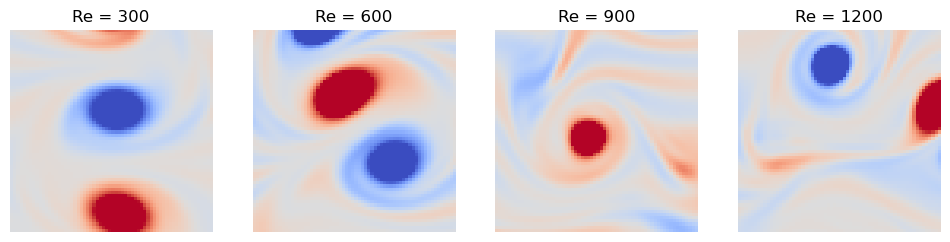

In [97]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i, re in enumerate([300, 600, 900, 1200]):
    ax[i].imshow(dataset.reshape(dataset.X[dataset.y == re][0]), cmap='coolwarm', vmin=-.005, vmax=.005)
    ax[i].set_title(f"Re = {re}")
    ax[i].axis("off")
plt.show()

### Before fitting a model, check the data

We first perform an unsupervised embedding, and color the points by the true Reynolds number. 

+ We see that the data is not linearly separable, so this is likely a non-trivial learning problem

Text(0, 0.5, 'PCA Component 2')

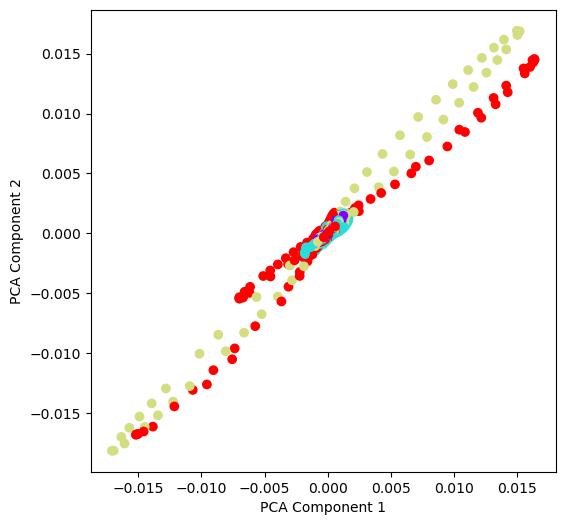

In [103]:
from sklearn.decomposition import PCA

## Perform PCA on the dataset
pca = PCA(n_components=2)
pca.fit(dataset.X_train)

## Plot the PCA components
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(dataset.X_train[:, 0], dataset.X_train[:, 1], c=dataset.y_train, cmap='rainbow')
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")

### Are the classes balanced?

Fraction of class 1200: 0.261
Fraction of class 1200: 0.244
Fraction of class 1200: 0.251
Fraction of class 1200: 0.244


Text(0, 0.5, 'Number of Samples in Training Set')

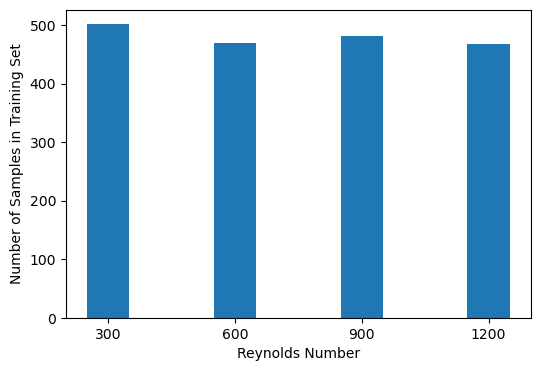

In [104]:
### Are the classes balanced?
class_ids = np.unique(dataset.y_train)
counts = list()
for id in class_ids:
    print(f"Fraction of class {re}: {np.mean(dataset.y_train == id):.3f}")
    counts.append(np.sum(dataset.y_train == id))

plt.figure(figsize=(6, 4))
plt.bar(class_ids, counts, width=100)
plt.xticks(class_ids)
plt.xlabel("Reynolds Number")
plt.ylabel("Number of Samples in Training Set")

### Generate baseline predictions

+ Since this is a regression problem, we will generate baseline predictions using a linear regression model

+ We will use the `sklearn` implementation of ridge regression

+ Instead of manually tuning the regularization parameter, we will use cross-validation to find the best value. `sklearn` has a built-in model that will perform this automatically, `RidgeCV`

In [105]:
from sklearn.linear_model import RidgeCV

## Train a linear model to predict the Reynolds number
model = RidgeCV()
model.fit(dataset.X_train, dataset.y_train)
y_pred = model.predict(dataset.X_test)

## Evaluate the model on the test set
print(f"Test set R^2: {model.score(dataset.X_test, dataset.y_test):.3f}")


Test set R^2: 0.205


# Let's try a neural network

+ Recall that a two-layer multilayer perceptron has the form

  $$
  \hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
  $$

  where $\sigma$ is an elementwise function (such as the logistic function), and $\boldsymbol{\theta}_1$ and $\boldsymbol{\theta}_2$ are trainable weight matrices.

+ For our problem, $\mathbf{x}$ is the flattened velocity field, and $\hat{\mathbf{y}}$ is the predicted Reynolds number. While the output is a scalar here, this isn't a requirement of the model.

+ We will use `scikit-learn`'s own implementation of a multi-layer perceptron (MLP) 

+ This implements a few architectural features and hyperparameters that would be difficult for us to implement ourselves: 
    + The "Adam" optimizer is a variant of gradient descent that uses adaptive learning rates and momentum
    + The "relu" activation function is a non-linear function that is more robust to vanishing gradients than the logistic function
    + The "batch size" is the number of samples used to compute the gradient at each step. This is a compromise between using the full dataset (which is slow) and using a single sample (which is noisy). 
    + The "epoch" is the number of times the entire dataset is used to compute the gradient.

R^2 score: 0.982845


Text(0, 0.5, 'Predicted Reynolds number')

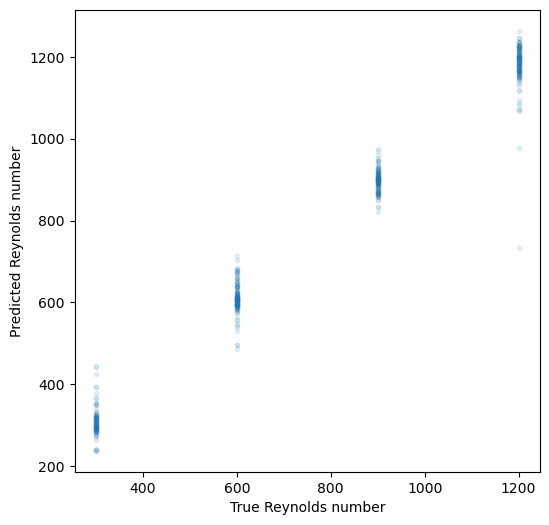

In [113]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(
    hidden_layer_sizes=(10, 10), 
    activation='relu', 
    solver='adam', 
    learning_rate='constant',
    learning_rate_init=0.001, 
    max_iter=1000, 
    random_state=0, 
    batch_size=32
)

# Fit the model to the data.
mlp.fit(dataset.X_train, dataset.y_train)

# Generate predictions on the test set.
y_test_pred = mlp.predict(dataset.X_test)

## Score using R^2
print("R^2 score: %f" % mlp.score(dataset.X_test, dataset.y_test))

plt.figure(figsize=(6, 6))
plt.plot(dataset.y_test, y_test_pred, '.', alpha=0.1)
plt.xlabel("True Reynolds number")
plt.ylabel("Predicted Reynolds number")

# How do we train a multilayer perceptron? Iterative optimization



Given a model 
$$
\hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$

with known true labels $y$ for every $\mathbf{x}$, we can update the weights with gradient descent:

$$\theta_{i+1} = \theta_i - \eta \frac{\partial \mathcal{L}}{\partial \theta_i}$$

where $\eta$ is the learning rate. Given a training set with $N$ examples, we usually take the average of the gradient computed over the $N$ examples.


### Linear model

We saw that linear regression and ridge regression have an analytic solution for the optimal weights. This is not the case for neural networks. Instead, we need to use gradient descent. It turns out that we can also frame linear regression as a neural network, and use the same gradient descent algorithm to train it. This is useful for large datasets, where pseudo-inverse methods are too slow.

A linear model is given by

$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_M$$

For linear regression, we typically use the mean-squared loss function,

$$\mathcal{L} = \frac{1}{2} \sum_{i=1}^N (\hat{y}_i - y_i)^2$$

$$
\frac{\partial \mathcal{L}}{\partial \theta_j} = \sum_{i=1}^N (\hat{y}_j - y_j) x_{ij}
$$

where $i$ indexes the data points and $j$ indexes the features.

### Logistic model:

The model is

$$\hat{y} = \frac{1}{1 + e^{-\theta_0 - \theta_1 x_1 - \theta_2 x_2 - \cdots - \theta_n x_M}}$$

Instead of mean-squared error, logistic models are often trained using cross-entropy loss:

$$\mathcal{L} = - \sum_{i=1}^N y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i)$$

$$
\frac{\partial \mathcal{L}}{\partial \theta_j} = -\sum_{i=1}^N \dfrac{1}{4} x_{ij} \log(2 y_i - 1) \text{sech}^2\left(\dfrac{\theta_j x_{ij}}{2}\right)
$$

where $i$ indexes the data points and $j = 1, 2, ..., M$ indexes the features. $\frac{\partial \mathcal{L}}{\partial \theta_j} \in \mathbb{R}^M$ is the gradient of the loss with respect to the weights.



### Multivariate Linear model

The model is

$$\hat{\mathbf{y}} = \boldsymbol{\theta} \mathbf{X}$$

where $\mathbf{x}$ is a $1 \times D$ matrix with $N$ data points and $D$ features, the weight matrix $\boldsymbol{\theta} \in \mathbb{R}^{M \times D}$ , and the prediction vector is $\hat{\mathbf{y}} \in \mathbb{R}^M$. Usually, we work with the data matrix $X = \{ \mathbf{x}_i \} \in \mathbb{R}^{N \times D}$.

The mean-squared loss function is

$$\mathcal{L} = \frac{1}{2} \sum_{i=1}^N (\hat{\mathbf{y}}_i - \mathbf{y}_i)^T(\hat{\mathbf{y}}_i - \mathbf{y}_i)$$

The gradient is

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}} = \sum_{i=1}^N (\hat{\mathbf{y}}_i - \mathbf{y}_i) \mathbf{x}_i^T
$$

Notice that the gradient is a matrix $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}}  \in  \mathbb{R}^{M \times D}$, where each row is the gradient of the loss with respect to the weights for a single output. This means that we have update values separately for each element of the weight matrix. Also, note that the right hand side is an outer product, while the forward pass is an inner product.

<!-- ### Neural network

The model is

$$\hat{y} = f(\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n)$$

where $f$ is a non-linear function. For example, $f$ could be a sigmoid function:

$$f(x) = \frac{1}{1 + e^{-x}}$$ -->




### Gradient descent requires us to take gradients of each trainable parameter with respect to the loss

+ Let's start by thinking about how we would do this in low dimensions

+ Suppose I wanted to take the gradient of the double well potential

$$
V(x) = x^4 - 2 x^2
$$

I could find the gradient analytically by taking the derivative

The gradient of the potential is
$$
\frac{\partial V}{\partial x} = 4 x^3 - 4 x
$$

In [ ]:
def double_well(x):
    """Double well potential function"""
    return x**4 - 2*x**2

def double_well_grad(x):
    """Derivative of double well potential function"""
    return 4*x**3 - 4*x

print(double_well(0.12132987))
print(double_well_grad(0.12132987))

### But we implicitly performed several subroutines to do this.

### Let's write out these functions in terms of basic computational steps



Given an $x$, computing $V(x)$ (the forward evaluation, or *forward pass*) can be broken up into

$$
h_1 = x^4
$$
$$
h_2 = 2 x^2
$$
$$
V = h_1 - h_2
$$



Now, given $V$, we want to compute $\frac{\partial V}{\partial x}$ (the backward evaluation, or *backward pass*). We can break this up into

$$
g_1 = 4 x
$$
$$
g_2 = 4 x^3
$$
$$
g_3 = -1
$$
$$
\frac{\partial V}{\partial x} = g_2 + g_3 g_1
$$

In [ ]:
def double_well_primitive(x):
    """Decompose the double well calculation into primitive operations"""
    h1a = x**4
    h1b = 2*x**2
    h2 = h1a - h1b
    return h2

def double_well_primitive_grad(x):
    """Decompose the double well gradient calculation into primitive operations"""
    dh2dh1a = 1
    dh2dh1b = -1
    dh1adx = 4*x**3
    dh1bdx = 4*x
    dh2dx = dh2dh1a * dh1adx + dh2dh1b * dh1bdx
    return dh2dx

print(double_well_primitive(0.12132987))
print(double_well_primitive_grad(0.12132987))

# Backpropagation is the chain rule on a computation graph


<img src="../resources/backprop1.png" width="750">
<img src="../resources/backprop2.png" width="750">

*Diagrams from [UW CSE599W lecture notes](https://dlsys.cs.washington.edu/pdf/lecture4.pdf)*

## Vector-valued functions

+ We can see that we were able to simplify the calculation by breaking the forward pass into discrete steps that got combined, and that the backward pass was able to reuse some of the intermediate calculations.

+ What if we go to higher dimensions? Recall that our neural network has a forward pass that looks like

$$
\hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$

where $\sigma$ is the logistic function. We combine a given prediction on a single datapoint $\hat{\mathbf{y}}$ with the true label $\mathbf{y}$ to compute the mean-squared error loss

$$
\mathcal{L} = \frac{1}{2} (\hat{\mathbf{y}} - \mathbf{y})^T (\hat{\mathbf{y}} - \mathbf{y})
$$

In order to perform gradient descent, we need to compute the gradient of the loss with respect to the weights $\boldsymbol{\theta}_1$ and $\boldsymbol{\theta}_2$. While the loss is a scalar, the gradient is a vector.

## Backpropagation through a multilayer perceptron

### Forward pass

When a trained neural network is given an input $\mathbf{x}$, it computes an output $\hat{\mathbf{y}}$ by passing the input through a series of layers. Each layer is a linear transformation followed by a non-linear function. For example, a two-layer network is given by

$$
\hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$
for concreteness, we will use the sigmoid nonlinearity $\sigma(x) = \frac{1}{1 + e^{-x}}$.

We start by breaking this into single steps

$$
\mathbf{h}_1^{u} = \boldsymbol{\theta}_1 \mathbf{x}
$$

$$
\mathbf{h}_1 = \sigma(\mathbf{h}_1^{u})
$$

$$
\mathbf{h}_2^{u} = \boldsymbol{\theta}_2 \mathbf{h}_1
$$

$$
\hat{\mathbf{y}} = \sigma(\mathbf{h}_2^{u})
$$


### Backward pass

Suppose we pass an input $\mathbf{x} \in \mathbb{R}^D$ and get an output $\hat{\mathbf{y}} \in \mathbb{R}^M$, and we know the true output is $\mathbf{y}\in \mathbb{R}^M$.

If we are using the mean-squared error loss function, then for a single training example $\mathbf{y}$, the loss $\mathcal{L} \in \mathbb{R}$ is

$$
\mathcal{L} = \frac{1}{2} (\hat{\mathbf{y}} - \mathbf{y})^\top(\hat{\mathbf{y}} - \mathbf{y})
$$

We want to update all the parameters $\boldsymbol{\theta}_1$ and $\boldsymbol{\theta}_2$ to minimize this loss.

To calculate $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_2} \in \mathbb{R}^{M \times H_2}$, we need to use the chain rule,

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_2} = \frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} \frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{h}_2^{u}} \frac{\partial \mathbf{h}_2^{u}}{\partial \boldsymbol{\theta}_2}
$$

In a *reverse-mode* chain rule evaluation, we can solving this sequence from left-to-right,

$$
\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} = \hat{\mathbf{y}} - \mathbf{y}
$$

$$
\frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{h}_2^{u}} = \hat{\mathbf{y}} (1 - \hat{\mathbf{y}})
$$

$$
\frac{\partial \mathbf{h}_2^{u}}{\partial \boldsymbol{\theta}_2} = \mathbf{h}_1^\top
$$

Putting this all together,

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_2} = (\hat{\mathbf{y}} - \mathbf{y}) \odot \hat{\mathbf{y}} (1 - \hat{\mathbf{y}}) \mathbf{h}_1^\top
$$

where $\odot$ is the element-wise product. Notice how we actually traversed the network *backwards*, starting with the gradient of the last evaluation we performed during the forward pass.

We can now compute the gradient for the first layer.

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_1} = 

\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} \frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{h}_2^{u}} 


 \frac{\partial \mathbf{h}_2^{u}}{\partial \mathbf{h}_1} \frac{\partial \mathbf{h}_1}{\partial \mathbf{h}_1^{u}} \frac{\partial \mathbf{h}_1^{u}}{\partial \boldsymbol{\theta}_1}
$$

We can combine the first two terms, which we already calculated above, and then solve from left to right.

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{h}_2^{u}} = (\hat{\mathbf{y}} - \mathbf{y}) \odot \hat{\mathbf{y}} (1 - \hat{\mathbf{y}}) \boldsymbol{\theta}_2^\top
$$

$$
\frac{\partial \mathbf{h}_2^{u}}{\partial \mathbf{h}_1} = \mathbf{h}_1 (1 - \mathbf{h}_1)
$$

$$
\frac{\partial \mathbf{h}_1}{\partial \mathbf{h}_1^{u}} = \mathbf{h}_1^{u} (1 - \mathbf{h}_1^{u})
$$

$$
\frac{\partial \mathbf{h}_1^{u}}{\partial \boldsymbol{\theta}_1} = \mathbf{x}^\top
$$

Putting this all together,

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_1} = (\hat{\mathbf{y}} - \mathbf{y}) \odot \hat{\mathbf{y}} (1 - \hat{\mathbf{y}}) \boldsymbol{\theta}_2^\top \odot \mathbf{h}_1 (1 - \mathbf{h}_1) \odot \mathbf{h}_1^{u} (1 - \mathbf{h}_1^{u}) \mathbf{x}^\top
$$



### Some things to note

+ Several of the "intermediate" values we computed during the forward pass re-appear when we perform the backwards pass. If we cached these values, then we don't have to recompute them during the backward pass. 

+ Notice that when we compute the "forward" pass we start with the innermost portion of the function composition, and then work our way out. For the backwards pass, we start with the outermost portion of the function composition, and work our way in. 

+ Notice that the sigmoid function's derivative is a function of its output. This is a common pattern in autodiff. 

+ In order to keep track of indicies and transposes, it helps to think about the dimensions of the input/output of each primitive operation.

+ It's useful to remember the some [rules for matrix multiplication:](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)

$$
\frac{\partial\mathbf{A} \mathbf{B}}{\partial \mathbf{A}} = \mathbf{B}^\top, \qquad
\frac{\partial\mathbf{A} \mathbf{B}}{\partial \mathbf{B}} = \mathbf{A}
$$
<!-- 
These left-right rules are also used in the derivation of the linear regression pseudoinverse global solution.

Additionally, we should remember the chain rule for derivatives:
$$
\frac{\partial\mathbf{A}(u) \mathbf{B}(u)}{\partial u} = \frac{\partial\mathbf{A}(u)}{\partial u} \mathbf{B}(u) + \mathbf{A}(u) \frac{\partial\mathbf{B}(u)}{\partial u}
$$ -->


# A reminder regarding indices...

For a single datapoint (vector) $\mathbf{x} \in \mathbb{R}^{d}$, the forward pass of a multilayer perceptron is
$$
\hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$

We normally aggregate many datapoints into a matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$, where $N$ is the number of datapoints. In this case, the forward pass returns $\hat{\mathbf{Y}} \in \mathbb{R}^{N \times 1}$, where each row is the prediction for a single datapoint. For some regression problems (such as the fluid forecasting problem on the homework), $\hat{\mathbf{Y}} \in \mathbb{R}^{N \times M}$

The first index, the data or "batch" index, is usually vectorized: it passes right through the model, since every data point has an output. The first index usually recieves special treatment in high-level packages like PyTorch and TensorFlow, since it is often used to aggregate gradients from multiple datapoints.

The loss function is usually a function of the entire dataset, including the batch index. For example, the mean squared loss is
$$
\mathcal{L}(X, \mathbf{y}, \boldsymbol{\theta}) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} (\hat{y}_i - y_i)^2
$$

For a multivariate prediction problem, the loss function is

$$
\mathcal{L}(X, Y, \boldsymbol{\theta}) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \|\hat{\mathbf{y}}_i - \mathbf{y}_i\|^2
$$

where $\hat{\mathbf{y}}_i \in \mathbb{R}^{M}$ and $\mathbf{y}_i \in \mathbb{R}^{M}$.


Importantly, when we compute gradients of the loss, we treat *the entire dataset* $X$, the true labels $Y$, and even the current predicted labels $\hat{Y}$ as a fixed set of constant parameters

## What does the code actually look like?

+ We will put all of these ideas together into a multilayer perceptron class. 

+ We will use the RELU activation function, and the mean-squared error loss function.

**Note: the code below doesn't work very well on this problem**

In [36]:
import numpy as np

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1.0, 0.0)

class MultiLayerPerceptron:
    """
    An MLP for regression with mean squared loss

    Attributes:
        hidden_layer_sizes (tuple): Number of neurons in each hidden layer
        activation (str): Activation function to use. Options are "relu", "tanh", and "identity"
        learning_rate (float): Learning rate for gradient descent
        max_iter (int): Maximum number of iterations to train for
        batch_size (int): Size of the mini-batches for gradient descent
        random_state (int): Random seed for reproducibility
        store_history (bool): Whether to store the training history


    """
    def __init__(self, hidden_layer_sizes=(100,), activation='relu', learning_rate=0.001, 
                 max_iter=1000, batch_size=32, store_history=False, random_state=0):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.random_state = random_state
        np.random.seed(self.random_state)
        
        self.weights = []
        self.biases = []
        self.store_history = store_history
        if self.store_history:
            self.history = []

    def loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred)**2)
    
    def initialize_parameters(self, input_size, output_size):
        """Initialize all model parameters using random numbers"""
        layer_sizes = [input_size] + list(self.hidden_layer_sizes) + [output_size]
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01 
                        for i in range(len(layer_sizes) - 1)]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]
    
    def forward_pass(self, X):
        """Given an input, compute the activations of all layers. The activations of the last layer
        are the predictions of the model"""
        activations = [X]
        for w, b in zip(self.weights, self.biases):
            z = np.dot(activations[-1], w) + b
            a = relu(z)
            activations.append(a)
        return activations
    
    def backward_pass(self, activations, y):
        """
        Given the activations of all layers and the true labels, compute the gradients of the
        loss with respect to the weights and biases of all layers
        """
        deltas = [(activations[-1] - y)]
        for i in reversed(range(len(self.weights)-1)):
            delta = np.dot(deltas[0], self.weights[i+1].T) * relu_derivative(activations[i+1])
            deltas.insert(0, delta)
        
        grad_w = [np.dot(activations[i].T, deltas[i]) for i in range(len(self.weights))]
        grad_b = [np.sum(deltas[i], axis=0, keepdims=True) for i in range(len(self.biases))]
        
        return grad_w, grad_b
    
    def update_parameters(self, grad_w, grad_b):
        """Given the gradients of the loss with respect to the weights and biases, update the
        weights and biases using gradient descent"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grad_w[i]
            self.biases[i] -= self.learning_rate * grad_b[i]
    
    def fit(self, X, y):

        # Promote y to a 2D array if it is 1D
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        
        self.initialize_parameters(X.shape[1], y.shape[1])
        for i in range(self.max_iter):
            for batch in range(0, X.shape[0], self.batch_size):

                # Random subsample a batch from the training set
                # This provides the stochastic part of the stochastic gradient descent 
                # algorithm
                X_batch = X[batch:batch+self.batch_size]
                y_batch = y[batch:batch+self.batch_size]
                
                # We cache all activations, not just the predictions
                activations = self.forward_pass(X_batch)
                grad_w, grad_b = self.backward_pass(activations, y_batch)
                self.update_parameters(grad_w, grad_b)
            
            if self.store_history:
                mse = self.loss(y, self.predict(X))
                self.history.append(mse)
        
    def predict(self, X):
        activations = self.forward_pass(X)
        return activations[-1]

mlp = MultiLayerPerceptron(hidden_layer_sizes=(10, 10), learning_rate=0.001, store_history=True)
mlp.fit(X_train, y_train)
predictions = mlp.predict(X_test)

plt.plot(mlp.history)



R^2 score: nan


### Harder cases: branching paths, loops, and shared weights

+ For more sophisticated architectures, we might have multiple paths through the network. For example, we might have a residual connection, where the output of the first layer is added to the output of the second layer.

+ Backpropagation is more complicated, but as long as everything is deterministic and continuous, it should still be possible to implement all gradients at nodes.

<img src="../resources/inceptionnet.png" width="350">

*Diagram from [Szegedy et al. (2014)](https://arxiv.org/abs/1409.4842)*

# Math is hard: Automatic Differentiation

+ Computing symbolic gradients of vector functions is exact but laborious

+ Finite-difference gradients are approximate, easy, but expensive in high dimensions:

+ + If the input to our network is $D$-dimensional, then we need to compute $2\,M$ gradients. For a 1 Megapixel image, this is a million gradient operations per gradient descent step

*Automatic differentiation* is a technique that can compute the *exact* gradient of a function in a computationally-efficient manner.

*Backpropagation* is just reverse-mode autodiff applied to train deep neural networks.

### Let the computer do the work

+ Most existing deep learning frameworks are built on top of autodiff

+ Tensorflow, PyTorch, JAX, and many others allow you to specify the neural network as a function composition graph, and can compute the gradient automatically as long as everything is differentiable

+ Implictly, these networks build a computation "graph" that is later traversed backwards to compute the gradient

+ Caching forward pass values can speed up the backwards pass, since many derivatives depend on forward pass values

In [242]:
import jax

def double_well(x):
    """Double well potential function"""
    return x**4 - 2*x**2

print("Forward pass value:", double_well(0.12132987))
print("Analytic calculation backwards pass", double_well_grad(0.12132987))
print("Jax autodiff backwards pass", jax.grad(double_well)(0.12132987))


Forward pass value: -0.029225168711847025
Analytic calculation backwards pass -0.4781751223381389
Jax autodiff backwards pass -0.4781751


In [282]:
import jax.numpy as jnp

a = jnp.array(np.random.random((5, )))
x = jnp.array(np.random.random((5, )))

def forward_pass(x, a):
    """Forward pass of a simple neural network"""
    return jnp.tanh(a.T @ x)

def backward_pass(x, a):
    """Backward pass of a simple neural network"""
    return (1 - np.tanh(a.T @ x)**2) * x.T

print("Forward pass value:\n", forward_pass(x, a))

print("\nAnalytic calculation backwards pass:\n", backward_pass(x, a))

print("\nJax autodiff backwards pass:\n", jax.grad(forward_pass, argnums=1)(x, a))
    

Forward pass value:
 0.5584225

Analytic calculation backwards pass:
 [0.19981267 0.21903262 0.0847854  0.421329   0.42325357]

Jax autodiff backwards pass:
 [0.19981267 0.21903262 0.0847854  0.421329   0.42325357]


### Some optimization tricks

+ Instead of "full batch" gradient descent, where we compute the average of the gradient $\nabla_\theta \mathcal{L}(\theta)$ over all training examples $x_i$, we can use *stochastic gradient descent*, where we randomly sample a *subset* of the training data during each gradient descent epoch. Smaller batch sizes are more noisy, while larger batch sizes are more accurate to the global geometry of the loss function.

+  Instead of just gradient descent, we can use momentum and many other tricks we saw in optimization:
    +  Stochastic
    +  Momentum
    +  Second-order methods (e.g. Newton's method)
    +  Adaptive learning rates
    +  Constrained Optimization (e.g. L1/L2 regularization)


+ Currently, many practioners use [the Adam optimizer](https://arxiv.org/abs/1412.6980), which is a combination of momentum and weight-based learning rate adjustment. Second-order methods are less commonly used for large problems, due to the expense of finding the full Hessian, but approximates methods based on its eigenvalues are viable.

# How do different hyperparameters affect training?

Two common hyperparameters that we'll encounter when training large networks are the learning rate $\eta$ and the batch size $B$.

+ Batch size $B$: The number of training examples used to compute the gradient. Larger batch sizes are better estimators of the overall gradient of the loss landscape, but more expensive to compute. Smaller batch sizes are more noisy, but can be faster to compute. The stochasticity of small batch sizes can also help the network avoid local minima.

+ Learning rate: The size of the step taken in the direction of the gradient. If the learning rate is too small, then the network will take a long time to converge. If the learning rate is too large, then the network will oscillate around the minimum, or even diverge.

+ We'll demonstrate these hyperparameters using `scikit-learn`'s own `MLPRegressor` class, which is a multilayer perceptron for regression problems. We'll use the `adam` iterative optimization algorithm, which is a combination of momentum and adaptive learning rates.

R^2 score: 0.999712


Text(0, 0.5, 'Loss')

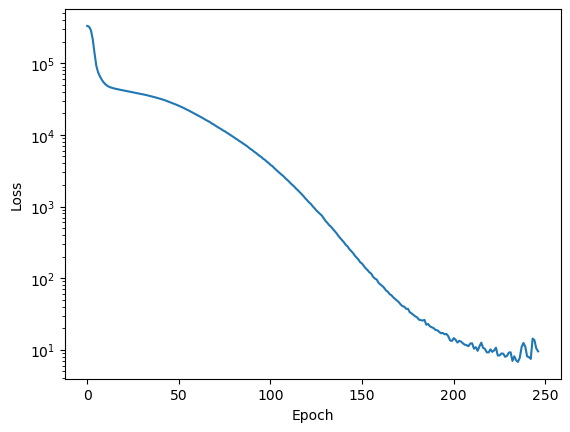

In [169]:
from sklearn.neural_network import MLPRegressor



mlp = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', learning_rate='constant',
                     learning_rate_init=0.001, max_iter=1000, random_state=0, batch_size=32)


X_train, X_test, y_train, y_test = dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test

mlp.fit(X_train, y_train)

## Score
print("R^2 score: %f" % mlp.score(X_test, y_test))

plt.semilogy(mlp.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')

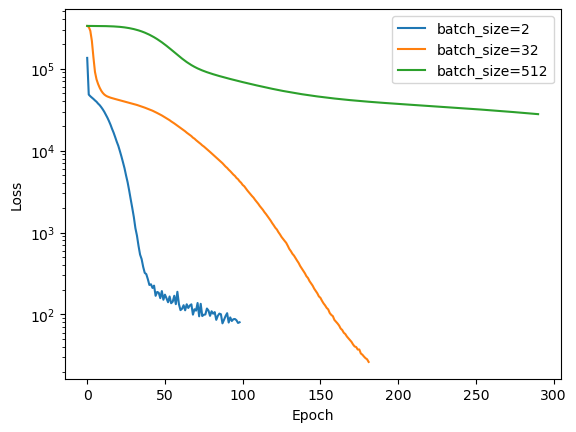

In [170]:
for batch_size_value in [2, 32, 512]:
    mlp = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', learning_rate='constant',
                     learning_rate_init=0.001, max_iter=1000, random_state=0, batch_size=batch_size_value)

    mlp.fit(X_train, y_train)
    plt.semilogy(mlp.loss_curve_, label=f"batch_size={batch_size_value}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Text(0, 0.5, 'Loss')

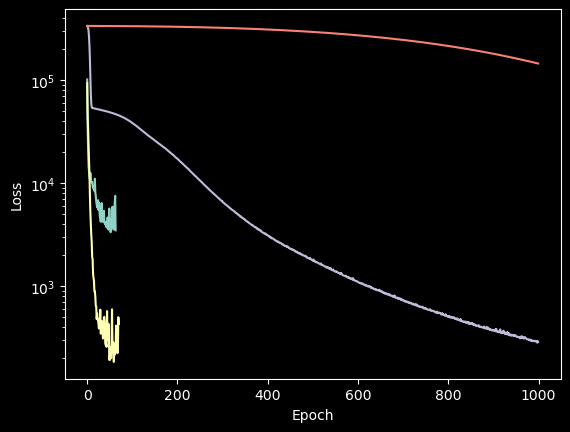

In [216]:
for lr in [1e0, 1e-1, 1e-3, 1e-5]:
    mlp = MLPRegressor(hidden_layer_sizes=(100, 100), 
                       activation='relu', 
                       solver='adam', 
                       learning_rate='constant',
                       learning_rate_init=lr, 
                       max_iter=1000, 
                       random_state=0,
                       batch_size=32)

    mlp.fit(X_train, y_train)
    plt.semilogy(mlp.loss_curve_, label=f"learning_rate={lr}")
plt.xlabel('Epoch')
plt.ylabel('Loss')